# Grocery Recommendation using Graph Network
> Building word2vec based Graph network using Instacart dataset and finding similar as well as neighbourhood items, and building a dash app

- toc: true
- badges: true
- comments: true
- categories: [Dash, App, NetworkX, Word2Vec, Graph, Retail, Visualization]
- image:

## Setup

In [86]:
!pip install -q dash dash-renderer dash-html-components dash-core-components
!pip install -q jupyter-dash

In [87]:
import re
import random
import pandas as pd
import numpy as np

import plotly.offline as py
import plotly.graph_objects as go

import networkx as nx
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

from gensim.models import Word2Vec

from tqdm.notebook import tqdm

import pickle

import dash
import dash_core_components as dcc
import dash_html_components as html
from jupyter_dash import JupyterDash
from dash.dependencies import Input, Output, State, ALL

In [92]:
!pip install -q watermark
%reload_ext watermark
%watermark -m -iv

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

numpy               : 1.19.5
networkx            : 2.5.1
seaborn             : 0.11.1
re                  : 2.2.1
sys                 : 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
pandas              : 1.1.5
dash                : 1.21.0
plotly              : 4.4.1
IPython             : 5.5.0
dash_html_components: 1.1.4
dash_core_components: 1.17.1
matplotlib          : 3.2.2



## Loading data

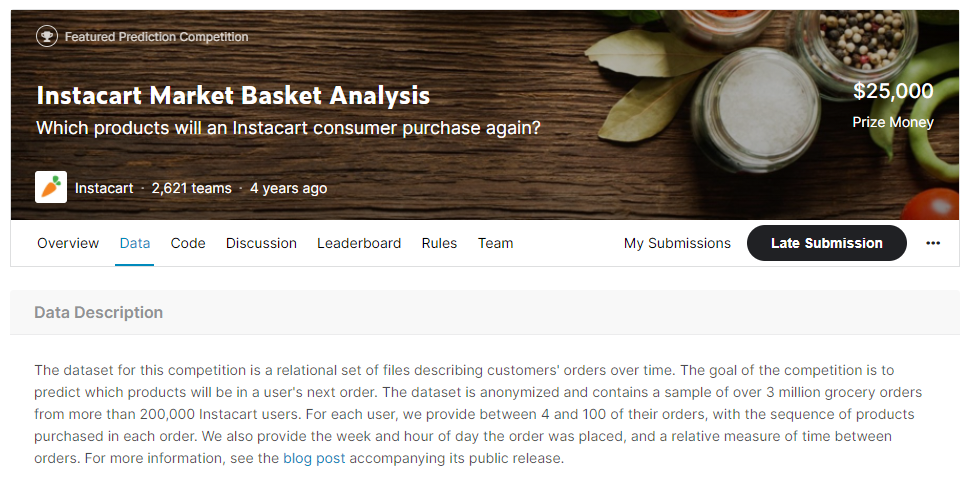

In [ ]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c instacart-market-basket-analysis
!unzip /content/instacart-market-basket-analysis.zip

In [10]:
!sudo apt-get install tree
!tree . -L 1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
.
├── aisles.csv.zip
├── departments.csv.zip
├── drive
├── instacart-market-basket-analysis.zip
├── order_products__prior.csv.zip
├── order_products__train.csv.zip
├── orders.csv.zip
├── products.csv.zip
├── __pycache__
├── sample_data
└── sample_submission.csv.zip

3 directories, 8 files


In [15]:
!unzip -qqo /content/order_products__train.csv.zip
train_df = pd.read_csv('order_products__train.csv')
train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [16]:
!unzip -qqo /content/products.csv.zip
products_df = pd.read_csv('products.csv')
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


## Preprocessing

In [17]:
def return_dfs(train_df, products_df, train_percent=0.1, products_cutoff=0,
               orders_q1=5, orders_q2=9):
    ''' Function that returns two dataframes for 2 segments of users based basket size
    Args:   train_file - the training dataframe
            products_file - the products dataframe
            train_percent - percentage of the train file sampled for this (smaller % makes viz possible)
            products_cutoff - only products appearing MORE often than this are included
            orders_q1 - first cutoff point for number of items in a basket
            orders_q2 - second cutoff point for number of items in a basket
    
    '''
    orders = train_df[['order_id', 'product_id']].copy()
    products = products_df.copy()
    
    # Get a wide range of orders
    order_ids = orders.order_id.unique()
    # Select a sample of the orders
    order_ids = random.sample(set(order_ids), int(len(order_ids)*train_percent))
    # Reduce the size of the initial orders data
    orders = orders[orders['order_id'].isin(order_ids)]
    
    
    # Take a look at the distribution of product counts
    counts = orders.groupby('product_id').count()
    counts.rename(columns = {'order_id':'count'}, inplace = True)
    counts.reset_index(inplace = True)
    # Remove the products occuring less often that products_cutoff
    product_ids = counts.product_id[counts['count'] > products_cutoff]
    
    # Filter for baskets of a certain size
    counts = orders.groupby('order_id').count()
    counts.rename(columns = {'product_id':'count'}, inplace = True)
    counts.reset_index(inplace = True)
    # Only keep baskets below orders_q1 size and between orders_q1 and orders_q2 size
    order_ids_Q1 = counts.order_id[counts['count'] <= orders_q1]
    order_ids_Q2  = counts.order_id[(counts['count'] <= orders_q2) & (counts['count'] > orders_q1)]
    
    # Create two dataframes for the orders
    orders_small = orders[orders['order_id'].isin(order_ids_Q1)]
    orders_small = orders_small[orders_small['product_id'].isin(product_ids)]
    orders_small = orders_small.merge(products.loc[:, ['product_id', 'product_name']], how = 'left')
    # To simplify what the orders look like, I've replaced 'bag of organic bananas' with just 'bananas'
    orders_small['product_name'] = orders_small['product_name'].replace({'Bag of Organic Bananas': 'Banana'})
    orders_small['product_name'] = orders_small['product_name'].str.replace('Organic ', '')

    orders_large = orders[orders['order_id'].isin(order_ids_Q2)]
    orders_large = orders_large[orders_large['product_id'].isin(product_ids)]
    orders_large = orders_large.merge(products.loc[:, ['product_id', 'product_name']], how = 'left')

    orders_large['product_name'] = orders_large['product_name'].replace({'Bag of Organic Bananas': 'Banana'})
    orders_large['product_name'] = orders_large['product_name'].str.replace('Organic ', '')
    
    return orders_small, orders_large, order_ids_Q1, order_ids_Q2

In [18]:
orders_small, orders_large, order_ids_Q1, order_ids_Q2 = return_dfs(train_df, products_df)

In [20]:
orders_small.head()

,order_id,product_id,product_name
0,719,45683,Heavy Duty Scrub Sponge
1,904,8013,Cup Noodles Chicken Flavor
2,904,46149,Zero Calorie Cola
3,988,45061,Natural Vanilla Ice Cream
4,988,28464,"Whipped Light Cream, Original"


In [21]:
orders_large.head()

,order_id,product_id,product_name
0,1,49302,Bulgarian Yogurt
1,1,11109,4% Milk Fat Whole Milk Cottage Cheese
2,1,10246,Celery Hearts
3,1,49683,Cucumber Kirby
4,1,43633,Lightly Smoked Sardines in Olive Oil


In [22]:
order_ids_Q1

3            719
4            904
5            988
14          3243
15          3817
          ...   
13099    3416849
13110    3419245
13113    3419891
13114    3420008
13117    3420798
Name: order_id, Length: 3978, dtype: int64

## Processing the Data for NetworkX
Here we need to create tuples comprising the paired items in the data so that we can build the graph. This code creates two sets of data, one for the "small" baskets and one for the "large" (although they're still quite small) baskets

In [25]:
paired_products_small = []

# Create the pairwise product combinations
for order_id in tqdm(order_ids_Q1):
    tmp_df = orders_small[orders_small['order_id'] == order_id]
    paired_products_small.extend(list(itertools.combinations(tmp_df.iloc[:, 2], 2)))
    
paired_products_large = []

# Create the pairwise product combinations
for order_id in tqdm(order_ids_Q2):
    tmp_df = orders_large[orders_large['order_id'] == order_id]
    paired_products_large.extend(list(itertools.combinations(tmp_df.iloc[:, 2], 2)))
    
counts_small = collections.Counter(paired_products_small)

counts_large = collections.Counter(paired_products_large)

food_df_small = pd.DataFrame(counts_small.most_common(1000),
                      columns = ['products', 'counts'])


food_df_large = pd.DataFrame(counts_large.most_common(4000),
                      columns = ['products', 'counts'])

In [26]:
# Turn one of the dataframes into a dictionary for processing into a graph
d = food_df_small.set_index('products').T.to_dict('records')
# d = food_df_large.set_index('products').T.to_dict('records')

In [34]:
dict(list(d[0].items())[0:10])

{('Banana', 'Baby Spinach'): 7,
 ('Banana', 'Clementines'): 11,
 ('Banana', 'Raspberries'): 9,
 ('Banana', 'Strawberries'): 13,
 ('Raspberries', 'Blackberries'): 12,
 ('Raspberries', 'Blueberries'): 14,
 ('Raspberries', 'Strawberries'): 14,
 ('Strawberries', 'Banana'): 8,
 ('Strawberries', 'Blueberries'): 10,
 ('Strawberries', 'Raspberries'): 12}

In [35]:
# Create and populate the graph object
G = nx.Graph()

for key, val in d[0].items():
    G.add_edge(key[0], key[1], weight = val)

# Take a look at how many nodes there are in the graph; too many and it's uncomfortable to visualise
nodes = list(G.nodes)
len(nodes)

527

In [36]:
# Prune the plot so we only have items that are matched with at least two others
for node in nodes:
    try:
        if G.degree[node] <= 1:
            G.remove_node(node)
    except:
        print(f'error with node {node}')

nodes = list(G.nodes)
len(nodes)

382

In [39]:
with open('large_graph.pickle', 'wb') as handle:
    pickle.dump(G, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Build the Word2Vec model
This section of the code focuses on building the Word2Vec-like embeddings for the nodes in the network using the Deep Walk procedure.

In [40]:
# Read the pickle in 
with open('large_graph.pickle', 'rb') as f:
    G_large = pickle.load(f)

In [90]:
def load_graph(segment):
    ''' Function that creates the graph of the graph based on the min number of edges
    Args: segment: indicates which segment: 0, 1, 2  to choose -> int
    Returns: graph and pos objects
    '''
    ### Load the data up
    segments = ['small_graph.pickle', 'med_graph.pickle', 'large_graph.pickle']

    with open(segments[segment], 'rb') as f:
        G = pickle.load(f)

    pos = nx.spring_layout(G)

    return pos, G

In [42]:
# Build a dictionary containing the weights of the edges; doing it this way saves a LOT of time in doing the probabilistic
# random walks in the next steps
weights = {}
for node in tqdm(G_large.nodes()):
    w_ = []
    for nodes in list(G_large.edges(str(node))):
        w_.append(G_large.get_edge_data(nodes[0], nodes[1])['weight'])
    weights[node]=w_    

In [43]:
def random_walk(graph, node, weighted=False, n_steps = 5):
    ''' Function that takes a random walk along a graph'''
    local_path = [str(node),]
    target_node = node
    
    # Take n_steps random walk away from the node (can return to the node)
    for _ in range(n_steps):
        neighbours = list(nx.all_neighbors(graph, target_node))
        # See the difference between doing this with and without edge weight - it takes many, many times longer
        if weighted:
            # sample in a weighted manner
            target_node = random.choices(neighbours, weights[target_node])[0]
        else:
            target_node = random.choice(neighbours)
        local_path.append(str(target_node))
        
    return local_path

Now we do the random walk and then we create the node embeddings



In [44]:
walk_paths_weighted = []

i = 0
for node in tqdm(G_large.nodes()):
    for _ in range(10):
        walk_paths_weighted.append(random_walk(G_large, node, weighted=True))

In [45]:
# Instantiate the embedder
embedder_weighted = Word2Vec(window = 4, sg=1, negative=10, alpha=0.03, min_alpha=0.0001, seed=42)
# Build the vocab
embedder_weighted.build_vocab(walk_paths_weighted, progress_per=2)
# Train teh embedder to build the word embeddings- this takes a little bit of time
embedder_weighted.train(walk_paths_weighted, total_examples=embedder_weighted.corpus_count, epochs=20, report_delay=1)

(381480, 458400)

In [65]:
some_random_words = [list(embedder_weighted.wv.vocab.keys())[x] for x in np.random.choice(len(embedder_weighted.wv.vocab),10)]
some_random_words

['Green Bell Pepper',
 'Natural Vanilla Ice Cream',
 'Avocado',
 'Baby Spring Mix',
 'Crimini Mushrooms',
 'Zucchini',
 'Total 0% Nonfat Plain Greek Yogurt',
 'Cold Brew Coffee Double Espresso with Almond Milk',
 'Half Baked® Ice Cream',
 'Vanilla Almond Breeze Almond Milk']

In [66]:
x_ = embedder_weighted.wv.most_similar(some_random_words[0], topn=10)
[i[0] for i in x_]

['Large Grade AA Brown Eggs',
 'Red Bell Pepper',
 'Milk, Organic, Fat Free',
 'Cucumber Kirby',
 'Chicken Thighs',
 'Red Onion',
 'Boneless Skinless Chicken Breast',
 'Large Extra Fancy Fuji Apple',
 'Popcorn Shrimp Oven Crispy',
 'Lorna Doone Shortbread Cookies']

In [67]:
x_ = embedder_weighted.wv.most_similar(some_random_words[1], topn=10)
[i[0] for i in x_]

['Classic Vanilla Coffee Creamer',
 'Whipped Light Cream, Original',
 'Complete ActionPacs Lemon Burst Dishwasher Detergent',
 'Raspberry Tea',
 'Medium Roast Original Blend Ground Coffee',
 'Original Fat Free Liquid Creamer',
 'Diet Peach',
 'Sriracha Sauce',
 'Just Mayo',
 'Taquitos, Crispy, Large, Vegan Chorizo & Black Bean Style 8 Count']

In [ ]:
## Save and/or load the embedding objects

# with open('embedder_weighted.pickle', 'wb') as f:
#     pickle.dump(embedder_weighted, f)

# with open('embedder_weighted.pickle', 'rb') as f:
#     embedder_weighted = pickle.load(f)

## Finding similar items

In [68]:
nodes = [node for node in G.nodes()]
pos = nx.spring_layout(G)
len(nodes)

382

In [84]:
def similar_embeddings(source_node, topn):
    ''' Function that returns the top ncounts most similar items using embeddings'''
    most_similar = embedder.wv.most_similar(source_node, topn=topn)
    return [i[0] for i in most_similar]

In [77]:
def find_ingredient(nodes, ingredient="Pear"):
    ''' Function that returns the closet match to an ingredient in the graph
    Args: ingredient: the ingredient you want to find -> str
          nodes: a list of the nodes in the graph -> list
    Returns: a list of the closest ingredients found
    '''
    ingredients = []

    for node in nodes:
        # This does a string-like search for the ingredient/item in each node
        # So ingredient="Pear" can return "Pear Jam", "Potato and Pear Soup" etc.
        if ingredient in node:
            ingredients.append(node)

    return ingredients

In [78]:
find_ingredient(nodes)

['Bartlett Pears', 'Sparkling Orange Juice & Prickly Pear Beverage']

In [79]:
find_ingredient(nodes, ingredient='Onion')

['Red Onion', 'Yellow Onions', 'French Onion Dip', 'Yellow Onion']

## Finding neighbour items

In [83]:
# Traverse the graph by selecting the most weighted item
def get_neighbours(G, item, topn=10):
    ''' Function that returns the neighbours of a node
    Args: G - the netwowrkx Graph object
          item: the start node for searching -> str
          topn: number of neighbours to return -> int
    Returns: a list of grocery items occuring in a basket together
    '''

    # items = list(G.neighbors(item))
    weights = {}
    # Get all the neighbours of a node and sort them by their edge weight
    for nodes in list(G.edges(str(item))):
        weights[nodes[1]] = G.get_edge_data(nodes[0], nodes[1])['weight']
    weights_sorted = {k: v for k, v in sorted(weights.items(), key=lambda x: x[1], reverse=True)}
    # Filter so we just have the topn items
    items = list(weights_sorted.keys())[0:topn]

    return items

## Using Plotly to make the graph interactive

In [73]:
def create_graph_display(G, pos):
    ''' Function for displaying the graph; most of this code is taken
        from the Plotly site
    Args:   G - networkx graph object
            pos - positions of nodes
    '''
    nodes = [node for node in G.nodes()]

    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        hoverinfo='text',
        hovertext="10",
        text="",
        textfont=dict(
            family="sans serif",
            size=11
        ),
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            reversescale=False,
            color=[],
            size=8,
            colorbar=dict(
                thickness=10,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=1))

    # Update the text displayed on mouse over
    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(G.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append(f'{nodes[node]}: {str(len(adjacencies[1]))} connections')

    node_trace.marker.color = node_adjacencies
    node_trace.hovertext = node_text

    return node_trace, edge_trace

In [74]:
node_trace, edge_trace = create_graph_display(G, pos)

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Graph of shopping cart items',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="some text",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )


fig.show()

## Building the Dash App

### Define the app

In [ ]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = JupyterDash(__name__, external_stylesheets=external_stylesheets)
server = app.server
app.title='Groceries on a graph'
list_dict = [{}]

### Load an initial Graph

In [ ]:
with open('large_graph.pickle', 'rb') as f:
    G_init = pickle.load(f)
nodes = list(G_init.nodes)

### Create a global button tracker

In [ ]:
BUTTON_CLICKED = None
button_style = {'margin-right': '5px',
               'margin-left': '5px',
               'margin-top': '5px',
               'margin-bottom': '5px'}

### Define Layout

In [ ]:
tabs_styles = {
    'height': '44px'
}
tab_style = {
    'borderBottom': '1px solid #d6d6d6',
    'padding': '6px',
    'fontWeight': 'bold'
}

tab_selected_style = {
    'borderTop': '0px solid #d6d6d6',
    'borderBottom': '1px solid #d6d6d6',
    'backgroundColor': '#1a1a1a',
    'color': 'white',
    'padding': '6px'
}

> Note: Layout comprises two tabs - one for viewing of the graph and the other for making a shopping list

In [ ]:
app.layout = html.Div([
    html.Div(className='row', children=[
        html.H1(children='Grocery Graph Network')
        ], style={'textAlign': 'center',
                  'backgroundColor': '#1a1a1a',
                  'color': 'white'}),
    html.Div([
    ## Show the tabs
    dcc.Tabs(id='tabs-example', value='tab-1',
             children=[
        dcc.Tab(label='Explore Network Graph', value='tab-1',
                style=tab_style,
                selected_style=tab_selected_style),
         dcc.Tab(label='Shopping List Builder', value='tab-2',
                 style=tab_style,
                 selected_style=tab_selected_style)
        ], style=tabs_styles
        )
    ]
    ),
    html.Div(id='tabs-output')
])

### Callback for selecting/changing tabs

In [ ]:
@app.callback(Output('tabs-output', 'children'),
              Input('tabs-example', 'value'))
def render_content(value):
    if value == 'tab-1':
        return display_network_graph()
    elif value == 'tab-2':
        return display_shopping_list()

### Function for displaying the network graph


In [91]:
def display_network_graph():
    ''' Function that displays the network tab'''

    # Setup a dropdown menu for the inputs to the graph
    dd_segment = dcc.Dropdown(
        id='dd_segment',
        className='dropdown',
        options=[{'label': 'Small', 'value': 0},
                 {'label': 'Medium', 'value': 1},
                 {'label': 'Large', 'value': 2}],
        value=2
    )
    # Create a div for the input settings, which includes the dropdown declared above
    input_settings = html.Div([
        html.Div(className='row', children=[
                    html.Div(className='col',
                        children=[
                            html.H4("Select Segment"),
                            html.P("Select a segment, named according to basket size"),
                            dd_segment
                        ],
                        style={'width': '30%', 'display': 'inline-block'}
                    )
            ]),
         # Display the main graph, with loading icon whilst loading
         html.Div(className='row', children=[
                    html.Div(children=[
                        dcc.Loading(id='loading-icon',
                                    children=[
                                        dcc.Graph(id='graph-graphic')
                                    ])
                    ])
                  ])
    ])

    return input_settings

### Function for displaying the items on the shopping recommender/list tab

In [ ]:
def display_shopping_list():
    return html.Div([
        html.Div(className='row', children=[
            html.Div(className='col', children=[
                html.P("Description: Search for items to start building your shopping list. \
                Once you've selected an item, similar items will be recommended to you")
            ])
        ]),
        html.Div(className='row', children=[
            html.Div(className='six columns', children=[
                html.Div(className='row', children=[
                    # Search box in here
                    html.H3("Search items"),
                    dcc.Input(
                        id='item_search',
                        type='search',
                        placeholder='Search Shopping Items',
                        debounce=True,
                        value='Pears'
                    ),
                    html.P(""),
                    # Radio items to choose how
                    html.P("Method for making recommendations: "),
                    dcc.RadioItems(id='sim-radio',
                                   options=[{'label': 'Similar', 'value': 'similar'},
                                            {'label': 'Neighbours', 'value': 'neighbours'}],
                                   value='similar',
                                   labelStyle={'display': 'inline-block'}),

                    html.P(""),
                    html.P(id='explainer',
                           children=["The items below are the closest that match your search"],
                           style={'font-weight': 'bold'}),
                    html.P("")
                ]
                ),
                 # Container that loads the items closest to what you searched for or
                 # recommended items
                 html.Div(className='row', id='button-container', children=[]

            )],
            ),
            html.Div(className='six columns', children=[
                html.Div(className='row', children=[
                    html.Div(className='six columns', children=[html.H3("Your Shopping List")])
                ]),
                # Dyanamic shopping list is built here
                html.Div(className='row', id='shopping-list-container', children=[]
                    )
                ],

             )

        ])
    ])

### Callback for displaying similar/neighbor items (tab 2)

In [ ]:
@app.callback(
    Output('button-container', 'children'),
    Output('shopping-list-container', 'children'),
    Output('explainer', 'children'),
    [Input('item_search', 'value'),
    Input({'type': 'button', 'index': ALL}, 'n_clicks'),
    Input('sim-radio', 'value')],
    [State('button-container', 'children'),
    State('shopping-list-container', 'children'),
    State('explainer', 'children')]
)
def display_search_buttons(item, vals, sim_val, buttons, shopping_list_items, explainer_text):
    ''' Function that runs all of the updates on for the shopping list'''
    ctx = dash.callback_context
    # Make the text in the same format as the times
    item = item.title()

    # If something has been triggered and it's the page loading or it's an item searched for
    # then load the items as per what was searched for
    if ctx.triggered is not None and \
            ctx.triggered[0]['prop_id'] == '.' or \
            ctx.triggered[0]['prop_id'] == 'item_search.value':
        buttons = []
        # Search for shopping items based on the item typed in the search bar
        # and create buttons
        shopping_items = find_ingredient(nodes, item)
        # Sort the items by length to make the display look nicer
        shopping_items.sort(key=len)
        counter = 0
        for i, it in enumerate(shopping_items):
            new_button = html.Button(
                f'{it}',
                id={'type': 'button',
                    'index': it
                },
                n_clicks=0,
                style=button_style
            )
            counter += 1
            buttons.append(new_button)
            # Stop too many items from being added
            if counter > 20:
                break
            explainer_text = r"""The items below are the closest that match your search"""

    # Check a button was clicked & that it's at least the first click (no auto clicks when the page loads)
    # & it's not the search input being searched in and it's not the radio button being checked
    elif ctx.triggered and ctx.triggered[0]['value'] != 0 and \
            ctx.triggered[0]['value'] is not None and \
            ctx.triggered[0]['prop_id'] != 'item_search.value' and \
            ctx.triggered[0]['prop_id'] != 'sim-radio.value':

        # Get the name of the grocery item
        button_clicked = re.findall(r':"(.*?)"', ctx.triggered[0]['prop_id'])[0]
        # track the button clicked for the next elif
        global BUTTON_CLICKED
        BUTTON_CLICKED = button_clicked
        # Add it to the shopping list
        new_item = html.P(
            f'{button_clicked}'
        )
        shopping_list_items.append(new_item)

        # Erase the list of ingredients and present similar ingredients by searching the graph
        buttons, explainer_text = recommend_groceries(button_clicked, sim_val)

    # Check if someone does something and if that something is changing the value on the
    # similarity measure radio button and
    elif ctx.triggered is not None and \
            BUTTON_CLICKED is not None and \
            ctx.triggered[0]['prop_id'] == 'sim-radio.value':
        buttons, explainer_text = recommend_groceries(BUTTON_CLICKED, sim_val)

    return buttons, shopping_list_items, explainer_text

### Function that returns a list of recommended groceries

In [ ]:
def recommend_groceries(button_clicked, sim_val):
    ''' Function that returns a list of recommended groceries
    Args:  button_clicked - the button (item) clicked by the user
            sim_val - the type of similarity the user wants for recommendations
                    either 'similar' or 'neighbours'
    Returns: a list of recommended items for the user
    '''
    buttons = []
    # Get recommendations based on the similarity method chosen by the user
    if sim_val == "similar":
        recommendations = similar_embeddings(button_clicked, 10)
    else:
        recommendations = get_neighbours(G_init, button_clicked)
    # Update the explainer so the user knows what's going on
    explainer_text = r"""These items are recommended based on the last item added to your basket"""

    # Stop a system-hanging number of recommendations being added
    if len(recommendations) > 20:
        recommendations = recommendations[:20]
    # Sort the recommendations based on how many words each comprises; this makes the display
    # look nicer
    recommendations.sort(key=len)
    # Add the recommended items to the buttons for adding to the shopping list
    for i, it in enumerate(recommendations):
        new_button = html.Button(
            f'{it}',
            id={'type': 'button',
                'index': it
                },
            n_clicks=0,
            style=button_style
        )
        buttons.append(new_button)
    return buttons, explainer_text

### Callback for updating the graph network

> Note: Graph display will update when the user changes the segment size

In [88]:
@app.callback(
    Output('graph-graphic', 'figure'),
    [Input('dd_segment', 'value')]
)
def update_graph(segment):
    ''' Function to load a pre-computed graph network based on the segment selected by
        the user in the dropdown
    Args:   segment - the segment selected by the user in the dropdown
    '''
    # Load the graph data and create the nodes and elements needed for display
    pos, G = load_graph(segment=segment)

    node_trace, edge_trace = create_graph_display(G, pos)
    # Display the graph
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title='',
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        annotations=[dict(
                            text="",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002)],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )

    return fig

In [89]:
app.run_server(mode='external')

Dash app running on:


<IPython.core.display.Javascript object>

### Analyzing callback map

This is retrieved from the dash layout

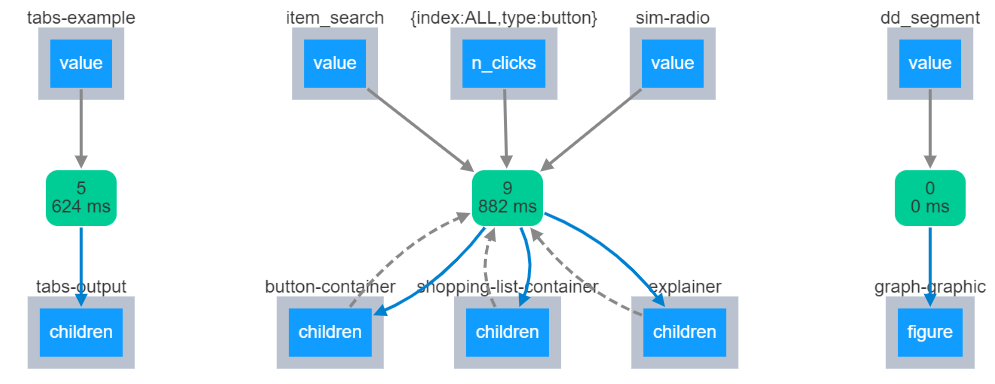

### Tab 1 visual

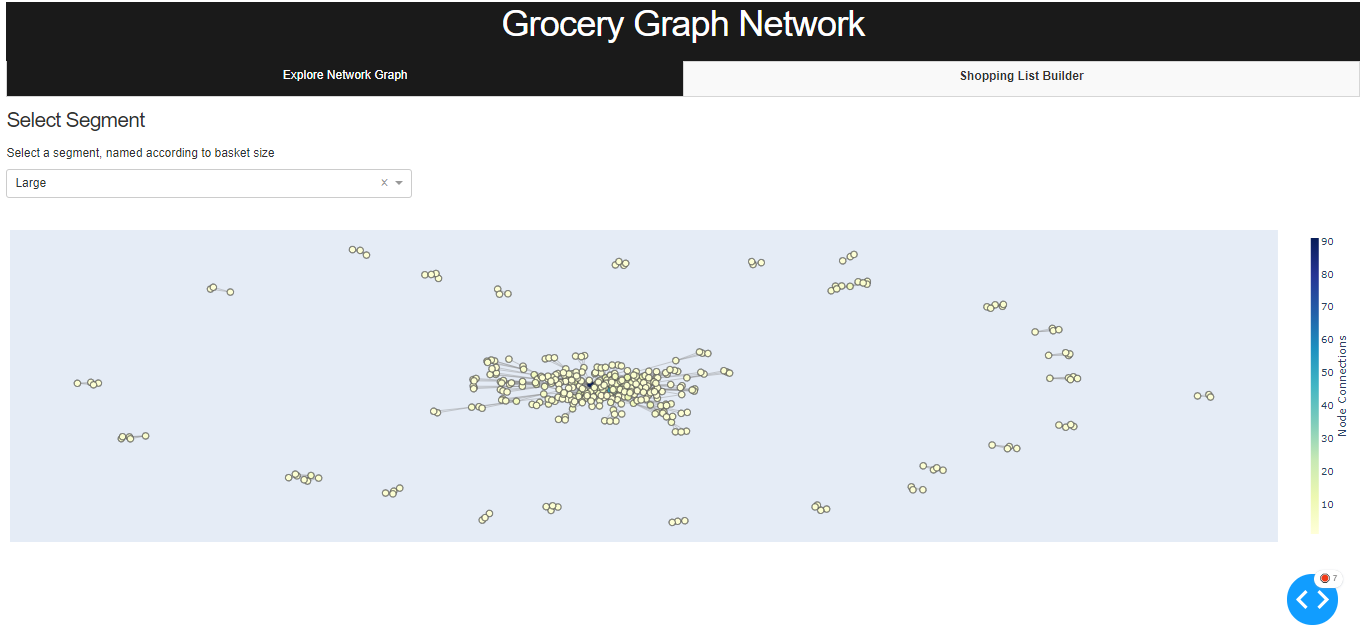

### Tab 2 visual

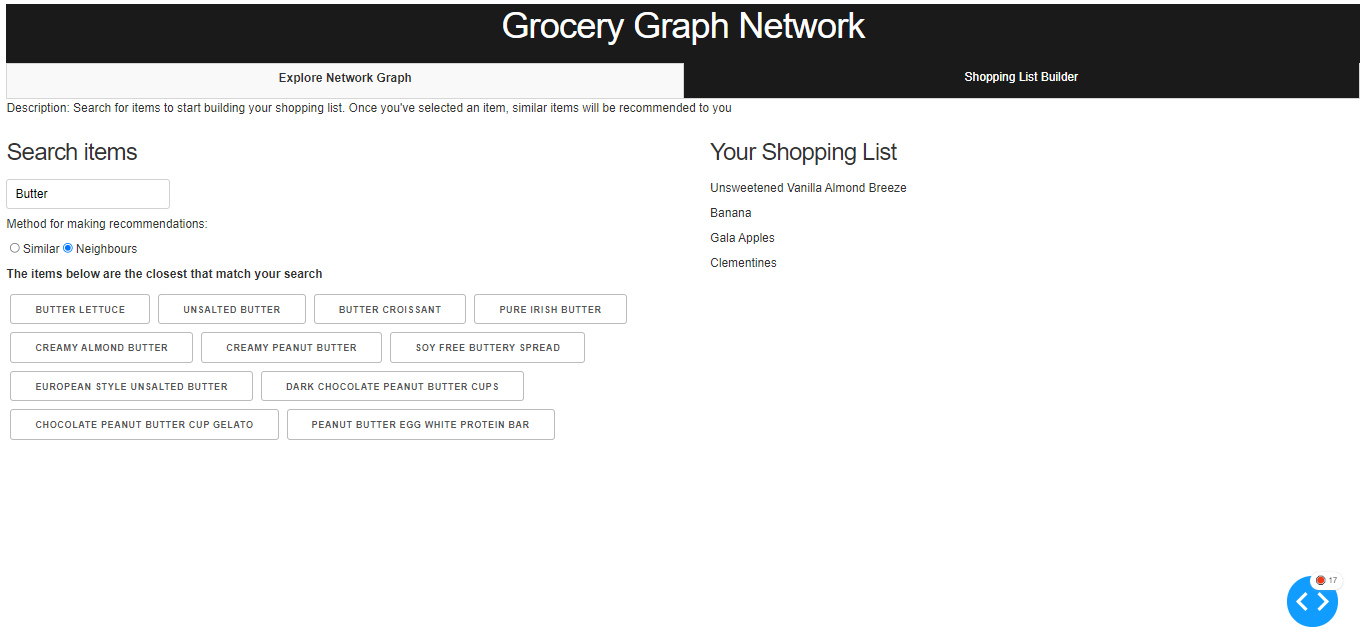